<a href="https://colab.research.google.com/github/what54210/what54210-Machine-Learning/blob/main/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#從我的雲端硬碟解壓縮到這裡
import zipfile
f = zipfile.ZipFile("drive/My Drive/未命名資料夾/train.zip")
f.extractall()

In [ ]:
#把貓狗用表格做分類
import pandas as pd
import glob
#glob.glob（pathname), 返回所有匹配的文件路徑列表。它只有一個參數pathname，定義了文件路徑匹配規則，這裏可以是絕對路徑，也可以是相對路徑
dogs = glob.glob("train/dog.*")
cats = glob.glob("train/cat.*")

df = pd.DataFrame({
    "path":dogs + cats,
    "target":[0] * len(dogs) + [1] *len(cats)
})
df

,path,target
0,train/dog.9287.jpg,0
1,train/dog.2877.jpg,0
2,train/dog.8792.jpg,0
3,train/dog.4978.jpg,0
4,train/dog.981.jpg,0
...,...,...
24995,train/cat.10328.jpg,1
24996,train/cat.517.jpg,1
24997,train/cat.257.jpg,1
24998,train/cat.10261.jpg,1


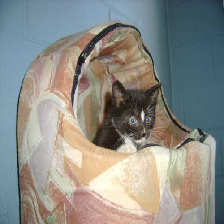

In [ ]:
import random
from tensorflow.keras.preprocessing.image import load_img
idx = random.randint(0, 24999)
load_img(df["path"][idx], target_size=(224, 224))

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

x, y = np.array(df["path"]), np.array(df["target"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22500,)
(2500,)
(22500,)
(2500,)


In [ ]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
cnn = vgg16.VGG16(include_top=False, input_shape=(224, 224, 3)) #include_top：是否保留顶层的3个全连接网络

# freeze一定要在Compile之前
for l in cnn.layers:
    l.trainable = False
mlp = [
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + mlp)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer=Adam(),
       metrics=["accuracy"])

In [ ]:
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
import numpy as np

def getdata(x, y, batch=20):
    idx = np.random.randint(0, x.shape[0], size=batch)
    orix, batchx, batchy = [], [], y[idx]
    for p in x[idx]:
        img = load_img(p, target_size=(224, 224))
        img_np = np.array(img)
        orix.append(img_np)
        img_pre = vgg16.preprocess_input(img_np)
        batchx.append(img_pre)
    return (np.array(orix), np.array(batchx), np.array(batchy))

testori, testx, testy = getdata(x_train, y_train, 20)
print(testori.shape)
print(testx.shape)
print(testy.shape)

(20, 224, 224, 3)
(20, 224, 224, 3)
(20,)


In [ ]:
testimg, testx, testy = getdata(x_test, y_test, 200)

for i in range(20):
    print("-" * 15, i, "-" * 15)
    trainimg, trainx, trainy = getdata(x_train, y_train, 20)
    result = model.train_on_batch(trainx, trainy)
    print("Train:", result)
    result = model.test_on_batch(testx, testy)
    print("Validate:", result)

--------------- 0 ---------------
Train: [0.09374253451824188, 0.949999988079071]
Validate: [0.324791818857193, 0.9649999737739563]
--------------- 1 ---------------
Train: [7.748597852241801e-08, 1.0]
Validate: [0.33624374866485596, 0.9649999737739563]
--------------- 2 ---------------
Train: [8.743236321606673e-06, 1.0]
Validate: [0.34318557381629944, 0.9649999737739563]
--------------- 3 ---------------
Train: [0.0005112966755405068, 1.0]
Validate: [0.3497348129749298, 0.9649999737739563]
--------------- 4 ---------------
Train: [0.10337001085281372, 0.949999988079071]
Validate: [0.3452760577201843, 0.9649999737739563]
--------------- 5 ---------------
Train: [0.000573662924580276, 1.0]
Validate: [0.34087878465652466, 0.9649999737739563]
--------------- 6 ---------------
Train: [0.1506081223487854, 0.949999988079071]
Validate: [0.33892184495925903, 0.9649999737739563]
--------------- 7 ---------------
Train: [3.015946504092426e-06, 1.0]
Validate: [0.33699488639831543, 0.970000028610

In [ ]:
# model.predict(trainx)
testimg, testx, testy = getdata(x_test, y_test, 1000)
model.evaluate(testx, testy)

32/32 [==============================] - 4s 116ms/step - loss: 0.1810 - accuracy: 0.9720


[0.18102605640888214, 0.972000002861023]

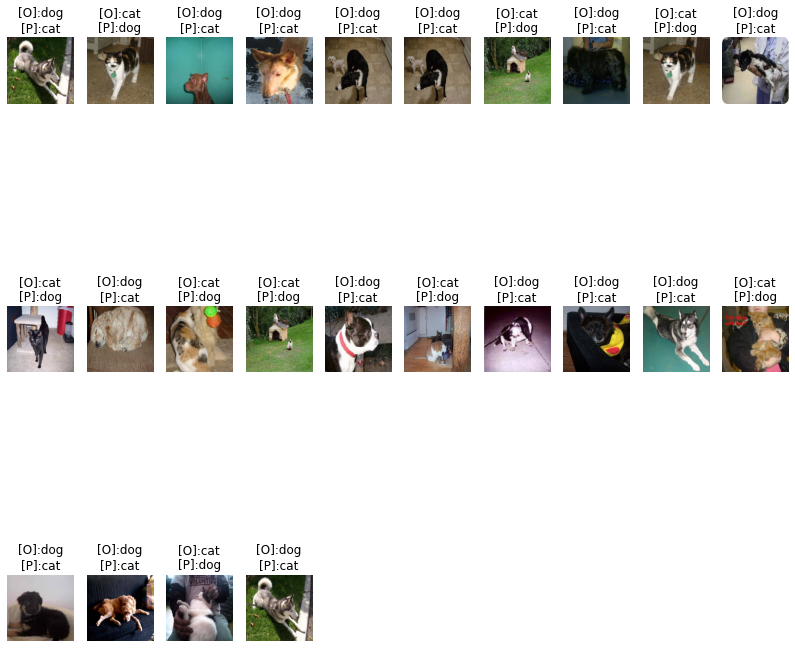

In [ ]:

# subplot(總高度, 總寬度, ith)
import numpy as np
import matplotlib.pyplot as plt

testimg, testx, testy = getdata(x_test, y_test, 1000)
pre = model.predict_classes(testx)
trans = ["dog", "cat"]

idx = np.nonzero(pre != testy)[0]
idx = idx[:200]
false_img = testimg[idx]
false_label = testy[idx]
false_pre = pre[idx]

plt.figure(figsize=(14, 14))
width = 10
height = len(false_img) // width + 1
for i in range(len(false_img)):
    plt.subplot(height, width, i+1)
    title = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(title)
    plt.axis("off")
    plt.imshow(false_img[i])

輸入網址:https://ichef.bbci.co.uk/news/976/cpsprodpb/41CF/production/_109474861_angrycat-index-getty3-3.jpg


/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


dog 的機率是: 0.0
cat 的機率是: 1.0
應該是: cat


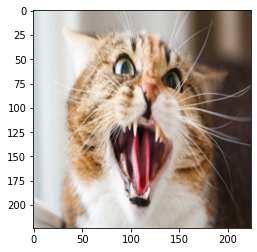

In [ ]:
# pip install pillow
import PIL
import requests
url = input("輸入網址:")
h = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36"
}
response = requests.get(url, stream=True, verify=False, headers=h)
img = PIL.Image.open(response.raw).resize((224, 224))
img_np = np.array(img)
test = vgg16.preprocess_input(img_np.reshape(1, 224, 224, 3))
probs = model.predict(test)[0]
for i, p in enumerate(probs):
    print(trans[i], "的機率是:", round(p, 3))
ans = model.predict_classes(test)[0]
print("應該是:", trans[ans])
plt.imshow(img_np)